# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *Ludovica Mazza*

**Matricola**: *1917778*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

### **References**

Keras 3 API documentation / KerasNLP / Models / Bert / BertClassifier model:

https://keras.io/api/keras_nlp/models/bert/bert_classifier/

 Keras 3 API documentation / KerasNLP / KerasNLP Models:

 https://keras.io/api/keras_nlp/models/

LoRA official paper:

https://arxiv.org/pdf/2106.09685.pdf

LoRA official implementation:

https://github.com/microsoft/LoRA/blob/main/loralib/layers.py

### **Install necessary libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-nlp
!pip install pynvml

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import keras
import keras_nlp
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.utils import shuffle
import time
import pynvml

Using TensorFlow backend


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
keras.__version__

'2.15.0'

In [ ]:
keras_nlp.__version__

'0.7.0'

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

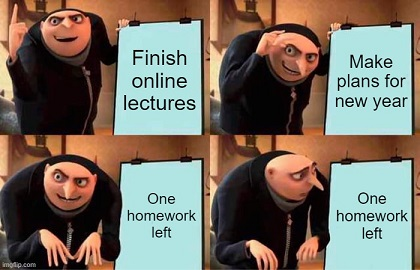

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a SHORT description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

The [dataset](https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset) I chose contains both AI-generated and human-written essays: the challenge is to detect whether an essay was written by a student or an LLM.

The dataset contains more than 29,000 essays written by students and generated by artificial intelligence.



In [ ]:
# TODO: Insert all code here.

In [ ]:
# Import data
data = pd.read_csv('/content/drive/MyDrive/NNDS_HW2/Training_Essay_Data.csv')

In [ ]:
# We have a column containing the text and a binary column that tells us who the text was written by
data.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


#### Let's do a little exploratory analysis to understand how are structured the data we work with

How many essays do we have?

In [ ]:
print('Total number of essays: {}'.format(len(data)))

Total number of essays: 29145


How many essays written and how many generated?

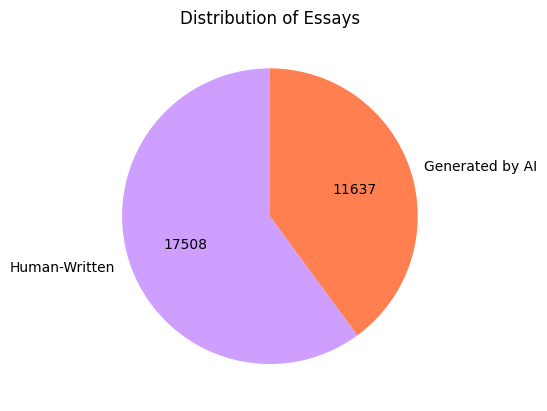

In [ ]:
values=data['generated'].value_counts()
colors = ['#CF9FFF', '#FF7F50']

plt.pie(values, labels = ["Human-Written", "Generated by AI"], autopct= lambda x: '{:.0f}'.format(x*values.sum()/100), colors=colors, startangle=90)
plt.title("Distribution of Essays")
plt.show()

Let's take a look at how the texts and sentences that make up each essay are distributed

In [ ]:
def insights(df):
    # get the number of words in each essay
    df['text_length'] = df['text'].str.len()
    # get the number of sentences in each text
    df['sentences'] = df['text'].map(lambda tex: nltk.sent_tokenize(tex))
    df['sentence_length'] = df['sentences'].map(lambda x: len(x))
    return df

data2 = insights(data)

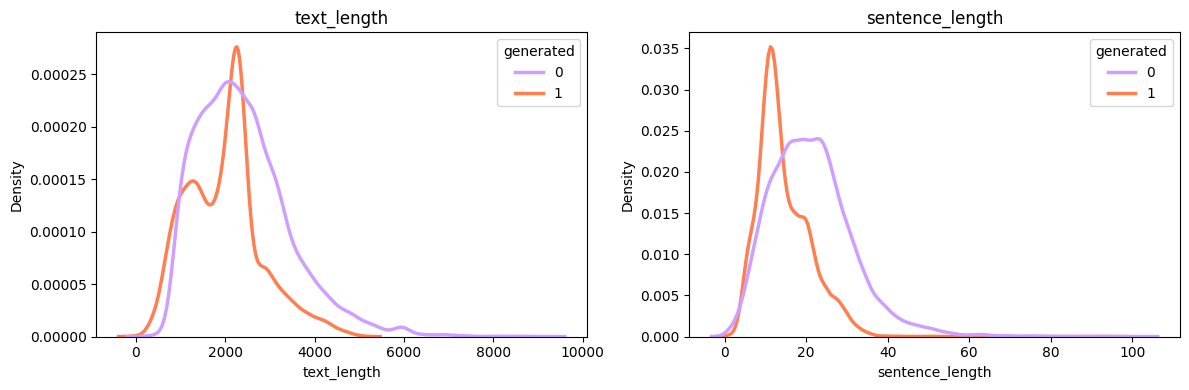

In [ ]:
def visualize(col, ax):
    custom_palette = {0: "#CF9FFF", 1: "#FF7F50"}
    sns.kdeplot(data=data2, x=col, hue="generated", ax=ax, palette=custom_palette, linewidth=2.5)
    ax.set_title(col)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

visualize("text_length", ax=axes[0])
visualize("sentence_length", ax=axes[1])
plt.tight_layout()
plt.show()

What are the most frequently used words in texts written by humani? And those most used in LLM-generated texts?  

In [ ]:
# Create separate strings for human-generated and AI-generated texts
human_text = ' '.join(data[data['generated'] == 0]['preprocessed_text'])
ai_text = ' '.join(data[data['generated'] == 1]['preprocessed_text'])

wordcloud_human = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(human_text)
wordcloud_ai = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(ai_text)

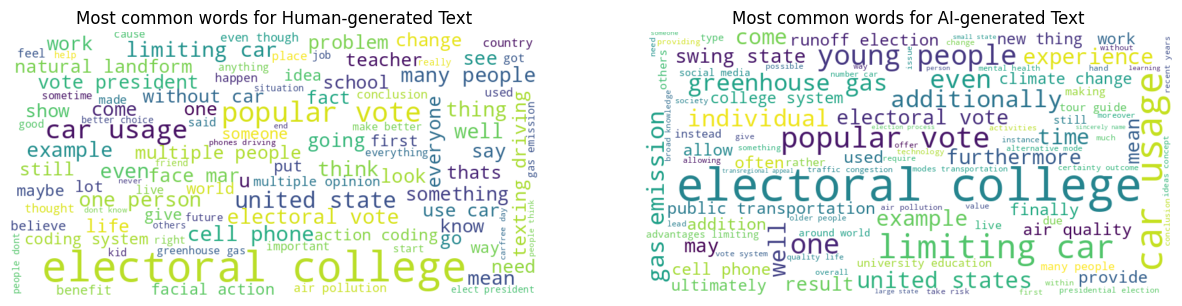

In [ ]:
# Plot the WordClouds
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_human, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words for Human-generated Text')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ai, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words for AI-generated Text')

plt.show()

Let's move on to data preprocessing

Are there any special characters in the texts other than alphanumeric? A lot! 75 to be precise.

In [ ]:
special_characters = set()
for text in data['text']:
    special_characters.update(char for char in text if not char.isalnum() and not char.isspace())
print('Special Characters:', special_characters)

Special Characters: {'}', '/', '"', ':', '!', '@', '£', '♡', '\xad', '–', ';', '\\', '`', '\x97', '¢', '😊', '>', '─', '\x91', '¡', '=', '?', '\u200b', '°', '\x92', '\x80', '😜', '(', '¶', '\x93', '%', '\x94', '-', '\x9b', '‒', '—', '·', '¸', '_', '\x83', ']', '{', '😁', '¬', '^', '~', '️', '”', '‘', '\x99', ')', "'", '&', '\x82', '™', '“', '.', '☺', '―', '´', '’', '<', '¨', ',', '©', '$', '|', '́', '…', '*', '+', '®', '[', '•', '#'}


Let's build a function to preprocess the text column

In [ ]:
# Create a set of English stop words - since the essays are written in english
STOP_WORDS = set(stopwords.words('english'))

def preprocessing(tex):
  # Convert text to lowercase
  tex = tex.lower()
  # Remove special characters using regular expressions
  tex = re.sub('[' + re.escape(''.join(special_characters)) + ']', '', tex)
  # Tokenize the text, remove stop words, and join the remaining words into a string
  tex = " ".join([word for word in tex.split() if word not in STOP_WORDS])
  return tex

In [ ]:
data["preprocessed_text"]=data['text'].apply(preprocessing)

In [ ]:
data.head()

,text,generated,preprocessed_text
0,Car-free cities have become a subject of incre...,1,carfree cities become subject increasing inter...
1,"Car Free Cities Car-free cities, a concept ga...",1,car free cities carfree cities concept gaining...
2,A Sustainable Urban Future Car-free cities ...,1,sustainable urban future carfree cities emergi...
3,Pioneering Sustainable Urban Living In an e...,1,pioneering sustainable urban living era marked...
4,The Path to Sustainable Urban Living In an ...,1,path sustainable urban living age rapid urbani...


Now that we have the text properly preprocessed, we can proceed with the advanced transfer learning step.

### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code.*

I decided to implement BERT and to use LoRA for finetuning.

As far as the BERT model is concerned, I got the "bert_small_en_uncased" architecture, which consist of 4-layer BERT model where all input is lowercased.

In total, there are 28.76M trainable parameters.

Like all other language models, a model like this is over-parametrized for "classical" fine-tuning.

This is where Low-Rank Adaptation comes in:  LoRA is a parameter-efficient fine-tuning technique that involves freezing the weights of the model and introducing trainable rank-decomposition matrices.

Let's briefly explain how does it work in order to understand the following steps.

LoRA operates on the premise that updates to the weights of pre-trained language models exhibit a low "intrinsic rank" due to their over-parametrization.
Therefore, the predictive performance achieved through full fine-tuning can be replicated by constraining the updates of the weight matrix to low-rank decomposition matrices.

Mathematically speaking:

Consider a pre-trained dense layer (or weight matrix) $W_0$ with dimensions $n\times n$. We initialize two dense layers, A and B, with shapes $n\times rank$ and $rank\times n$, respectively, where rank is considerably smaller than n (values between 1 and 4 effectively yield positive results, as demonstrated in the paper).

So, in the original equation, we have: $output = W_0x + b_0$, where x is the input, and $W_0$ and $b_0$ are the weight matrix and bias terms of the original dense layer (frozen).
On the other hand, the LoRA equation expands to $output = W_0x + b_0 + BAx$, incorporating the rank-decomposition matrices A and B.

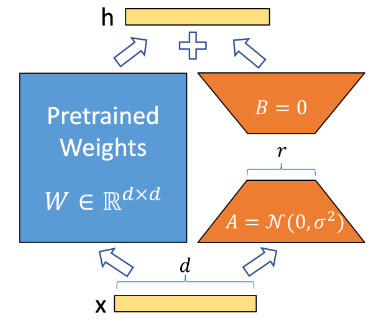


It is easy to see by doing some quick math that, in the end, by freezing the original dense layer, the number of trainable parameters will eventually be much less than the original ones.

This will lead to a reduction in both training time and GPU memory usage, all the while preserving the quality of the outputs.

In order to really understand the benefits of using advanced transfer learning techniques, I decided to also try classical fine-tuning and compare the training time and gpu memory usage of a fine-tuned model in the "classical" way with my LoRA-BERT model.

Let us proceed with the implementation and observe the results.

We start by defining the train and test datasets.

In [ ]:
X = data['preprocessed_text']
y = data['generated']
# Shuffle the data
X, y = shuffle(X, y, random_state=42)

In [ ]:
# Define train and test data
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

Import the ***preprocessor***, which is BERT preprocessing layer which tokenizes and packs inputs.

This preprocessing layer will do three things:
1. Tokenize any number of input segments using the tokenizer.
2. Pack the inputs together with the appropriate "[CLS]", "[SEP]" and "[PAD]" tokens.
3. Construct a dictionary with keys "token_ids", "segment_ids", "padding_mask", that can be passed directly to a BERT model.

In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_small_en_uncased")

100%|██████████| 547/547 [00:00<00:00, 530kB/s]
100%|██████████| 226k/226k [00:00<00:00, 1.09MB/s]


Import the model.

In [ ]:
model = keras_nlp.models.BertClassifier.from_preset(
    "bert_small_en_uncased", preprocessor=preprocessor, num_classes=2
)

What does the model look like?

This model is a BERT-based classifier which uses a BERT preprocessor.
The tokenizer employed is a BERT tokenizer with a vocabulary size of 30,522.

The main classifier takes three input layers: padding_mask, segment_ids, and token_ids.
The backbone of the model is a BERT backbone, it includes a dropout layer and the final layer is a dense layer with 2 output units, indicating a binary classification task.
The total number of parameters in the model is 28,764,674, with all of them being trainable.

In [ ]:
model.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone (BertBackbone)                  │ {sequence_output: (None, None, 512),   │      28,763,648 │
│                                               │ pooled_output: (None, 512)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                           │ (None, 512)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,026 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 28,764,674 (109.73 MB)

 Trainable params: 28,764,674 (109.73 MB)

 Non-trainable params: 0 (0.00 B)

Now let's see what happens with classic fine tuning.

In [ ]:
# Define the optimizer and the loss
optimizer= keras.optimizers.AdamW(
        learning_rate=5e-5,
        weight_decay=0.001
    )

loss = keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Configure the model for training
model.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)

In [ ]:
# Record the time taken for each epoch during model training
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.start_time = time.time()
        self.times = []

    def on_epoch_end(self, epoch, logs={}):
        epoch_time = time.time() - self.start_time
        self.times.append(epoch_time)

def get_gpu_memory_usage():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return info.used / (1024**2)  # memory usage in MB

# Monitor GPU memory usage during model training, recording the memory consumption at the end of each epoch.
class MemoryUsageCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.start_memory = get_gpu_memory_usage()
        self.memory_usages = []

    def on_epoch_end(self, epoch, logs={}):
        end_memory = get_gpu_memory_usage()
        total_memory_usage = end_memory - self.start_memory
        self.memory_usages.append(total_memory_usage)

time_callback = TimeHistory()
memory_callback = MemoryUsageCallback()

In [ ]:
# Check if GPU is available
local_device_protos = device_lib.list_local_devices()
gpu_available = any(device.device_type == 'GPU' for device in local_device_protos)

if gpu_available:
    print("GPU is available")
    # Check if model is running on GPU
    print("Model is running on GPU" if 'GPU' in local_device_protos[1].name else "Model is not running on GPU")
else:
    print("GPU is not available")

GPU is available
Model is running on GPU


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=3, callbacks=[time_callback, memory_callback])

In [ ]:
# Total training time
total_train_time = time_callback.times[-1]
print("Total Training Time: {:.2f} seconds".format(total_train_time))

# Total GPU memory usage
total_memory_usage = memory_callback.memory_usages[-1]
print("Total GPU Memory Usage: {:.2f} MB".format(total_memory_usage))

Total Training Time: 1611.66 seconds
Total GPU Memory Usage: 5764.00 MB


In [ ]:
# Evaluate the performances
model.evaluate(X_test,y_test)

183/183 [==============================] - 53s 280ms/step - loss: 0.0391 - accuracy: 0.9873


[0.03910147398710251, 0.9873048663139343]

Let us proceed with the implementation of LoRA.

All results will be commented on at the end so that we have the necessary information to compare the two techniques.

In [ ]:
class Lora(keras.layers.Layer):
    def __init__(
        self,
        dense_layer,
        rank=4,
        trainable=False,
        normal_kernel_init=False,
        kaiming_kernel_init=False,
    ):

        # initialize the layer base class
        dense_layer_config = dense_layer.get_config()
        name = dense_layer_config["name"]
        super().__init__(name=name, trainable=trainable)

        # define the scale factor --> i decided to use alpha = 1 as specified in section 10.2
        # of "Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning"
        self.rank = rank
        self._scale = 1 / rank

        # extracting information about the output shape of the dense layer
        # this will be useful when computing the matrix_B of LoRA
        self.out_shape=dense_layer_config["output_shape"]
        self._num_heads = self.out_shape[-2]
        self._hidden_dim = self._num_heads * self.out_shape[-1]

        # defining the kernel initialization's possibilities --> the original paper mentions that normal distribution was
        # used, however, the official LoRA implementation uses "Kaiming/He"
        self.normal_kernel_init = normal_kernel_init
        self.kaiming_kernel_init = kaiming_kernel_init

        if normal_kernel_init == True:
          kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.05)

        if kaiming_kernel_init == True:
          kernel_initializer = keras.initializers.VarianceScaling(scale=math.sqrt(5), mode="fan_in", distribution="uniform")

        # freeze the weights of the dense layer --> we only need to train LoRA parameters
        self.dense_layer = dense_layer
        self.dense_layer.trainable = False


        # Defining LoRA matrices A and B
        # Matrix A
        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            kernel_initializer=kernel_initializer,
            trainable=trainable,
            name=f"matrix_A",
        )

        # Matrix B
        self.B = keras.layers.EinsumDense(
            equation=dense_layer_config["equation"],
            output_shape=self.out_shape,
            kernel_initializer="zeros",
            trainable=trainable,
            name=f"matrix_B",
        )


    # when the layer is called:
    def call(self, inputs):
        if self.trainable == True:
          # compute LoRA output and add it to the original layer's output.
          lora_output = self.B(self.A(inputs)) * self._scale
          return self.dense_layer(inputs) + lora_output
        # if the layer is not trainable --> return the output of the original layer
        return self.dense_layer(inputs)

In [ ]:
# load again the model --> ready to inject LoRA
lora_model = keras_nlp.models.BertClassifier.from_preset(
    "bert_small_en_uncased", preprocessor=preprocessor, num_classes=2
)

100%|██████████| 508/508 [00:00<00:00, 28.1kB/s]
100%|██████████| 110M/110M [00:02<00:00, 38.9MB/s]
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [ ]:
# Iterate over the backbone
for i in range(lora_model.backbone.num_layers):

    # take the self-attention layer from the decoder layer
    decoder_layer = lora_model.backbone.get_layer(f"transformer_layer_{i}")
    self_attention_layer = decoder_layer._self_attention_layer

    # Allow changes to the layer
    self_attention_layer.locked = False

    # replaces the query dense layer of the self-attention layer
    # with a new instance of the LoRA layer.
    self_attention_layer._query_dense = Lora(
        self_attention_layer._query_dense,
        rank=4,
        trainable=True,
        kaiming_kernel_init=True,
        normal_kernel_init = False,
    )

    # replaces the value dense layer of the self-attention layer
    # with a new instance of the LoRA layer.
    self_attention_layer._value_dense = Lora(
        self_attention_layer._value_dense,
        rank=4,
        trainable=True,
        kaiming_kernel_init=True,
        normal_kernel_init = False,
    )

In [ ]:
# check that everything is okay
lora_model(preprocessor(["check that everything is okay"]))
pass

In [ ]:
# iterates over each layer in the new lora_model and put the flattened layers into a list
for layer in lora_model._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers())
    # if there are not nested layers
    if len(lst_of_sublayers) == 1:
        # and if we're dealing with LoRA matrices --> set the layer as trainable
        if layer.name in ["matrix_A", "matrix_B"]:
            layer.trainable = True
        else:
            layer.trainable = False

What does the model look like after injecting LoRA?

In [ ]:
lora_model.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone (BertBackbone)                  │ {sequence_output: (None, None, 512),   │      28,796,416 │
│                                               │ pooled_output: (None, 512)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ dropout (Dropout)                             │ (None, 512)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,026 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 28,797,442 (109.85 MB)

 Trainable params: 32,768 (128.00 KB)

 Non-trainable params: 28,764,674 (109.73 MB)

As we can see, we now have only 32,768 trainable parameters.

It's time to fine-tune the model on our task.

In [ ]:
# Define the optimizer and the loss
optimizer= keras.optimizers.AdamW(
        learning_rate=5e-5,
        weight_decay=0.001
    )

loss = keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Configure the model for training
lora_model.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)

In [ ]:
# Record the time taken for each epoch during model training
class TimeHistory_LoRA(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.start_time = time.time()
        self.times = []

    def on_epoch_end(self, epoch, logs={}):
        epoch_time = time.time() - self.start_time
        self.times.append(epoch_time)

def get_gpu_memory_usage():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return info.used / (1024**2)

# Monitor GPU memory usage during model training, recording the memory consumption at the end of each epoch.
class MemoryUsageCallback_LoRA(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.start_memory = get_gpu_memory_usage()
        self.memory_usages = []

    def on_epoch_end(self, epoch, logs={}):
        end_memory = get_gpu_memory_usage()
        total_memory_usage = end_memory - self.start_memory
        self.memory_usages.append(total_memory_usage)

time_callback_lora = TimeHistory_LoRA()
memory_callback_lora = MemoryUsageCallback_LoRA()

In [ ]:
# Train the model
lora_model.fit(X_train, y_train, epochs=3, callbacks=[time_callback_lora, memory_callback_lora])

In [ ]:
# Total training time
total_train_time = time_callback_lora.times[-1]
print("Total Training Time: {:.2f} seconds".format(total_train_time))

# Total GPU memory usage
total_memory_usage = memory_callback_lora.memory_usages[-1]
print("Total GPU Memory Usage: {:.2f} MB".format(total_memory_usage))

In [ ]:
# Evaluate the performances
lora_model.evaluate(X_test,y_test)

183/183 [==============================] - 52s 278ms/step - loss: 0.2603 - accuracy: 0.9645


[0.26025599241256714, 0.9644879102706909]

Comparison in terms of training time and GPU memory usage:

LoRA-BERT:
- Total Training Time: 1290.15 seconds
- Total GPU Memory Usage: 4958.00 MB

Original BERT model:
- Total Training Time: 1611.66 seconds
- Total GPU Memory Usage: 5764.00 MB

In summary, combining the "small" BERT model with the Low-Rank Adaptation technique proved to be a working approach for our initial goal.

By taking advantage of the inherent overparameterization of pre-trained language models, LoRA efficiently reduces the number of trainable parameters, making the tuning process more efficient, speeding up the training and reducing the GPU memory usage without compromising the goodness of results.

In fact:
- Orignal BERT model accuracy: 98,73%
- LoRA-BERT model accuracy: 96,45%

### Exercise 2: Interpreting the results (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [ ]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

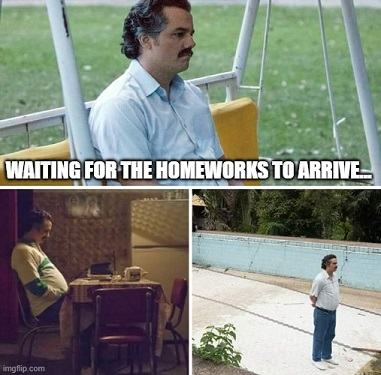